In [ ]:
try:
    import colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !wget https://gist.githubusercontent.com/Tviskaron/4d35eabce2e057dd2ea49a00b00aaa41/raw/f1e25fc6ac6d8f11cb585559ce8b2ab9ffefd67b/colab_render.sh -O colab_render.sh -q
    !sh colab_render.sh
    !wget https://gist.githubusercontent.com/Tviskaron/d91decc1ca5f1b09af2f9f080011a925/raw/0d3474f65b4aea533996ee00edf99a37e4da5561/colab_render.py -O colab_render.py -q 
    import colab_render

In [ ]:
import glob
import io
import base64
from IPython import display as ipythondisplay
from IPython.display import HTML
from gym.envs.classic_control import rendering
import matplotlib.pyplot as plt
%matplotlib inline

def show_video(folder="./video"):
    mp4list = glob.glob(folder + '/*.mp4')
    if len(mp4list) > 0:
        mp4 = sorted(mp4list, key=lambda x: x[-15:], reverse=True)[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

## Crossentropy Method

В этой пункте мы посмотрим на то, как решить задачи RL с помощью метода crossentropy.

Рассмотрим пример с задачей Taxi [Dietterich, 2000](https://arxiv.org/pdf/cs/9905014.pdf). 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

env = gym.make("Taxi-v3")
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [ ]:
n_states  = env.observation_space.n
n_actions = env.action_space.n  

print(f"состояний: {n_states} действий: {n_actions}")

состояний: 500 действий: 6


В этот раз нашей стратегией будет вероятностной распределение. 

$\pi(s,a) = P(a|s)$

Для задачи такси мы можем использовать таблицу: 

policy[s,a] = P(выбрать действие a | в состоянии s)

Создадим "равномерную" стратегию в виде двумерного массива с 
равномерным распределением по действиям и сгенерируем игровую сессию с такой стратегией

In [ ]:
def initialize_policy(n_states, n_actions):
    ####### Здесь ваш код ########
    policy = np.full((n_states, n_actions), 1. / n_actions)
    ##############################
    return policy

policy = initialize_policy(n_states, n_actions)

In [ ]:
assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

### Генерация сессий взаимодейтсвия со средой.

Мы будем запоминать все состояния, действия и вознаграждения за эпизод.

In [ ]:
def generate_session(env, policy, t_max=10**4):
    """
    Игра идет до конца эпизода или до t_max шагов в окружении. 
    :param policy: [n_states,n_actions] 
    :returns: states - список состояний, actions - список действий, total_reward - итоговое вознаграждение
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        # Подсказка: вы можете использовать np.random.choice для сэмплирования
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
        # a = 
        ####### Здесь ваш код ########
        a = np.random.choice(n_actions, p=policy[s])
        ##############################
        new_s, r, done, info = env.step(a)

        # Записываем информацию, который мы получили от среды.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward

In [ ]:
s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float]

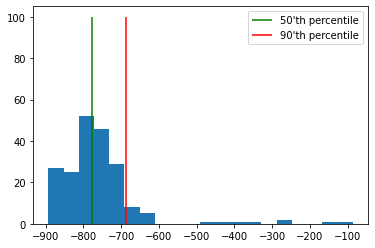

In [ ]:
# посмотрим на изначальное распределение вознаграждения
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Реализация метода crossentropy  

Наша задача - выделить лучшие действия и состояния, т.е. такие, при которых было лучшее вознаграждение:

In [ ]:
def select_elites(states_batch, actions_batch, 
                  rewards_batch, percentile=50):
    """
    Выбирает состояния и действия с заданным перцентилем (rewards >= percentile)
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]
    
    :returns: elite_states, elite_actions - одномерные 
    списки состояния и действия, выбранных сессий
    """
    # нужно найти порог вознаграждения по процентилю
    # reward_threshold =
    ####### Здесь ваш код ########
    reward_threshold = np.percentile(rewards_batch, percentile)
    ##############################
    
    
    # в соответствии с найденным порогом - заполнить списки 
    # elite_states и elite_actions, нужными состояниями и действиями
    elite_states = []
    elite_actions = []
    ####### Здесь ваш код ########
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states += states_batch[i]
            elite_actions += actions_batch[i]

    ##############################
    
    return elite_states, elite_actions

In [ ]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(
    test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1]) \
       and np.all(
    test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]), \
    "Для процентиля 0 необходимо выбрать все состояния " \
    "и действия в хронологическом порядке"

assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1])\
   and np.all(test_result_30[1] == [3, 2, 0, 1, 3, 3]), \
    "Для процентиля 30 необходимо выбрать " \
    "состояния/действия из [3:]"
assert np.all(test_result_90[0] == [3, 1]) and \
       np.all(test_result_90[1] == [3, 3]), \
    "Для процентиля 90 необходимо выбрать состояния " \
    "действия одной игры"
assert np.all(test_result_100[0] == [3, 1]) and \
       np.all(test_result_100[1] == [3, 3]), \
    "Проверьте использование знаков: >=,  >. " \
    "Также проверьте расчет процентиля"
print("Тесты пройдены!")


Тесты пройдены!


Теперь мы хотим написать обновляющуюся стратегию:

In [ ]:
def update_policy(elite_states,elite_actions):
    """
    Новой стратегией будет:
    policy[s_i,a_i] ~ #[вхождения  si/ai в лучшие states/actions]
    
    Не забудьте про нормализацию состояний.
    Если какое-то состояние не было посещено, 
    то используйте равномерное распределение 1./n_actions
    
    :param elite_states:  список состояний
    :param elite_actions: список действий
    """
    new_policy = np.zeros([n_states,n_actions])
    
    # обновляем стратегию - нормируем новые частоты
    # действий и не забываем про непосещенные состояния     
    ####### Здесь ваш код ########
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1
    
    for s in range(n_states):
        norm = new_policy[s].sum()
        if norm == 0:
            new_policy[s] = 1. / n_actions
        else:
            new_policy[s] /= norm

    ##############################
    return new_policy

In [ ]:
elite_states, elite_actions = (
    [1, 2, 3, 4, 2, 0, 2, 3, 1],
    [0, 2, 4, 3, 2, 0, 1, 3, 3])

new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(
    new_policy).all(), "Стратегия не должна содержать " \
                       "NaNs или +-inf. Проверьте " \
                       "деление на ноль. "
assert np.all(
    new_policy >= 0), "Стратегия не должна содержать " \
                      "отрицательных вероятностей "
assert np.allclose(new_policy.sum(axis=-1),
                   1), "Суммарная\ вероятность действий"\
                       "для состояния должна равняться 1"
reference_answer = np.array([
    [1., 0., 0., 0., 0.],
    [0.5, 0., 0., 0.5, 0.],
    [0., 0.33333333, 0.66666667, 0., 0.],
    [0., 0., 0., 0.5, 0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Тесты пройдены!")

Тесты пройдены!


### Цикл обучения

Визуализириуем наш процесс обучения и также будем измерять распределение получаемых за сессию вознаграждений 

In [ ]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    Удобная функция, для визуализации результатов.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

In [ ]:
# инициализируем стратегию
policy = initialize_policy(n_states, n_actions)

mean reward = -8.340, threshold=3.000


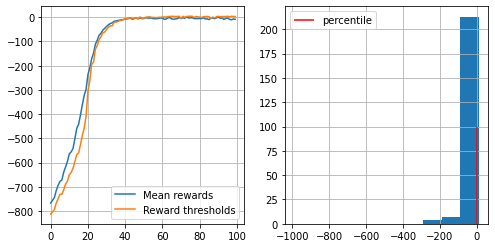

In [ ]:
n_sessions = 250  # количество сессий для сэмплирования
percentile = 30  # перцентиль 
learning_rate = 0.5 # то как быстро стратегия будет обновляться 

log = []

for i in range(100):
    # генерируем n_sessions сессий
    # sessions = []
    ####### Здесь ваш код ########
    sessions = [generate_session(env, policy) for _ in range(n_sessions)]
    ##############################
    
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    # отбираем лучшие действия и состояния ###
    # elite_states, elite_actions = 
    ####### Здесь ваш код ########
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    ##############################
    
    # обновляем стратегию
    # new_policy =
    ####### Здесь ваш код ########
    new_policy = update_policy(elite_states, elite_actions)
    ##############################
    
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # выводим график с результатами
    show_progress(rewards_batch, log, percentile)

### Посмотрим на результаты
Задача такси быстро сходится, начиная с вознаграждения -1000 к почти оптимальному значению, а потом опять падает до -50/-100. Это вызвано случайностью в самом окружении $-$ случайное начальное состояние пассажира и такси, в начале каждого эпизода. 

В случае если алгоритм CEM не сможет научиться тому, как решить задачу из какого-то стартового положения, он просто отбросит этот эпизод, т.к. не будет сессий, которые переведут этот эпизод в топ лучших. 

Для решения этой проблемы можно уменьшить threshold (порог лучших состояний) или изменить способ оценки стратегии, используя новую стратегию, полученную из каждого начального состояния и действия (теоретически правильный способ).

## Deep CEM. Закапываемся глубже.

В данной части мы рассмотрим применение CEM вместе с нейронной сетью.
Будем обучать многослойную нейронную сеть для решения простой задачи с непрерывным пространством действий.

<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2020/RL/figures/digging.svg">

Будем тестировать нашего нового агента на известной задаче перевернутого маятника, с непрерывным пространством состояний.
https://gym.openai.com/envs/CartPole-v0/

In [ ]:
env = gym.make("CartPole-v0")

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]
                                        
print(f"состояний: {state_dim} действий: {n_actions}")

состояний: 4 действий: 2


### Стратегия с нейронной сетью

Попробуем заменить метод обновления вероятностей на нейронную сеть. 
Будем пользоваться упрощенной реализацией нейронной сети из пакета Scikit-learn.
Нам потребуется: 
* agent.partial_fit(states, actions) - делает один проход обучения по данным. Максимизирует вероятность :actions: из :states:
* agent.predict_proba(states) - предсказыает вероятность каждого из действий, в виде матрицы размера [len(states), n_actions]

In [ ]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# инициализируем агента под заданное пространство состояний и действий
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [ ]:
def generate_session(env, agent, t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        # предсказываем вероятности действий по сети и 
        # выбираем одно действие
        # probs = 
        # a = 
        ####### Здесь ваш код ########
        probs = agent.predict_proba([s])[0] 
        a = np.random.choice(n_actions, p=probs)
        ##############################
        
        new_s,r,done,info = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward+=r
        
        s = new_s
        if done: break
    return states,actions,total_reward

In [ ]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("состояния:", np.stack(dummy_states))
print("действия:", dummy_actions)
print("вознаграждение:", dummy_reward)

состояния: [[ 2.06115247e-02  3.82195269e-02  1.20250615e-02 -4.10885677e-02]
 [ 2.13759153e-02 -1.57072779e-01  1.12032902e-02  2.55363994e-01]
 [ 1.82344597e-02 -3.52352882e-01  1.63105701e-02  5.51559465e-01]
 [ 1.11874020e-02 -5.47700066e-01  2.73417593e-02  8.49336360e-01]
 [ 2.33400725e-04 -7.43184012e-01  4.43284865e-02  1.15049016e+00]]
действия: [0, 0, 0, 0, 0]
вознаграждение: 5.0


mean reward = 191.240, threshold=200.000


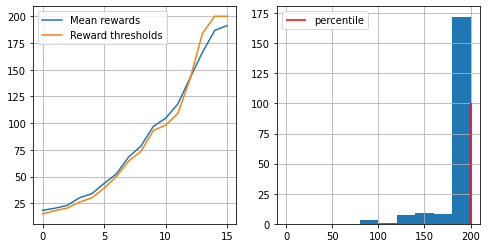

Принято!


In [ ]:
n_sessions = 200
percentile = 50
log = []

for i in range(100):
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
    
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch, percentile)
    
    # учим стратегию предсказывать в состояниях X=elite_states, 
    # действия y=elite_actions 
    ####### Здесь ваш код ########
    agent.fit(elite_states, elite_actions)
    ##############################
    
    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("Принято!")
        break


In [ ]:
env.close()

In [ ]:
env = gym.make("CartPole-v0")
env = gym.wrappers.Monitor(env, "./video", force=True)

generate_session(env, agent)

env.close()
show_video()